# RolX

This notebook implements role extraction to identify structural roles (hubs, bridges, peripherals)


## Imports

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from collections import defaultdict

## Load Data from Precomputed Parquet Files

In [14]:
artists_df = pd.read_parquet("../data/final_data_processed/discogs_artists.parquet")
edges_df = pd.read_parquet("../data/final_data_processed/discogs_edges.parquet")

# check if the data got loaded
print(f"Number of artists: {len(artists_df)}")
print(f"Number of edges: {len(edges_df)}")
print(f"\nEdge columns: {edges_df.columns.tolist()}")
print(f"\nFirst few edges:")
print(edges_df.head())

Number of artists: 1045947
Number of edges: 5673764

Edge columns: ['source_id', 'target_id', 'release_year']

First few edges:
  source_id target_id  release_year
0        92     17757          1999
1     33257      3482          2000
2        96        95          1999
3     12007    583687          1995
4       645      5823          2000


In [18]:
# remove edges that dont have a release year just in case
edges_with_year = edges_df[edges_df['release_year'].notna()].copy()
edges_with_year['release_year'] = edges_with_year['release_year'].astype(int)

# sort by year
edges_with_year = edges_with_year.sort_values('release_year')

print(f"Edges: {len(edges_with_year)}")
print(f"Range of edges is: {edges_with_year['release_year'].min()} - {edges_with_year['release_year'].max()}")
print(f"\n")
print("Year distribution:")
print(edges_with_year['release_year'].value_counts().sort_index())

# 80-20 split for testing
split = int(len(edges_with_year) * 0.8)
train_edges = edges_with_year.iloc[:split]
test_edges = edges_with_year.iloc[split:]


# make sure split is around 80-20
print(f"\nTrain edges: {len(train_edges)} (years {train_edges['release_year'].min()}-{train_edges['release_year'].max()})")
print(f"Test edges: {len(test_edges)} (years {test_edges['release_year'].min()}-{test_edges['release_year'].max()})")

Edges: 5673764
Range of edges is: 1897 - 2025


Year distribution:
release_year
1897         6
1898        10
1899         9
1900         2
1901        12
         ...  
2021    100345
2022     90968
2023     85656
2024     75493
2025     45304
Name: count, Length: 129, dtype: int64

Train edges: 4539011 (years 1897-2013)
Test edges: 1134753 (years 2013-2025)


## Build Train and Test Graphs

In [ ]:
# graph using training edges
G_train = nx.Graph()
for _, row in train_edges.iterrows():
    G_train.add_edge(row['source_id'], row['target_id'])

# remove all the isolated nodes
isolated_nodes = list(nx.isolates(G_train))
G_train.remove_nodes_from(isolated_nodes)

print(f"Training graph - Nodes: {G_train.number_of_nodes()}, Edges: {G_train.number_of_edges()}")
print(f"Density: {nx.density(G_train):.6f}")
print(f"Connected components: {nx.number_connected_components(G_train)}")

# get the largest connected component for further analysis
largest_cc = max(nx.connected_components(G_train), key=len)
G_train_lcc = G_train.subgraph(largest_cc).copy()
print(f"\nLargest connected component - Nodes: {G_train_lcc.number_of_nodes()}, Edges: {G_train_lcc.number_of_edges()}")

Training graph - Nodes: 658017, Edges: 1622034
Density: 0.000007
Density: 0.000007
Connected components: 117332
Connected components: 117332

Largest connected component - Nodes: 375947, Edges: 1409342

Largest connected component - Nodes: 375947, Edges: 1409342


## RolX Implementation - Feature Extraction

RolX extracts structural roles by:
1. Computing structural features for each node
2. Using recursive feature generation
3. Clustering nodes based on these features

We'll compute features like degree, clustering coefficient, and ego-network properties.

In [20]:
def feature_extraction(G):
    # get the easy degree and clustering since they are features
    degree = dict(G.degree())
    clustering = nx.clustering(G)
    
    # ego network features
    ego_features = {}
    for node in G.nodes():
        ego = nx.ego_graph(G, node, radius=1)
        ego_features[node] = {
            'ego_size': ego.number_of_nodes(),
            'ego_edges': ego.number_of_edges(),
            'ego_density': nx.density(ego) if ego.number_of_nodes() > 1 else 0
        }
    
    # neighbor features
    neighbor_degree = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor_degree[node] = {
                'mean_neighbor_degree': np.mean([degree[n] for n in neighbors]),
                'max_neighbor_degree': np.max([degree[n] for n in neighbors]),
                'min_neighbor_degree': np.min([degree[n] for n in neighbors])
            }
        else:
            neighbor_degree[node] = {
                'mean_neighbor_degree': 0,
                'max_neighbor_degree': 0,
                'min_neighbor_degree': 0
            }
    
    # combining together all the features
    all_features = []
    nodes_list = []
    
    for node in G.nodes():
        feature_vector = [
            degree[node],
            clustering[node],
            ego_features[node]['ego_size'],
            ego_features[node]['ego_edges'],
            ego_features[node]['ego_density'],
            neighbor_degree[node]['mean_neighbor_degree'],
            neighbor_degree[node]['max_neighbor_degree'],
            neighbor_degree[node]['min_neighbor_degree']
        ]
        all_features.append(feature_vector)
        nodes_list.append(node)
    
    feature_matrix = np.array(all_features)
    
    return feature_matrix, nodes_list

feature_matrix, nodes_list = feature_extraction(G_train_lcc)
print(f"Shape of feature matrix: {feature_matrix.shape}")
print(f"How many features are in each node: {feature_matrix.shape[1]}")

Shape of feature matrix: (375947, 8)
How many features are in each node: 8


## RolX - Role Discovery using NMF

Use Non-negative Matrix Factorization to discover latent roles from structural features.

In [24]:
# we need to normalize features, we are using a minmaxscaler to avoid the issues with negative numbers
scaler = MinMaxScaler()
feature_matrix_normalized = scaler.fit_transform(feature_matrix)

# discover roles
n_roles = 8 # tweak this to adjust the number of roles discovered
nmf = NMF(n_components=n_roles, init='nndsvda', random_state=42, max_iter=500)
role_membership = nmf.fit_transform(feature_matrix_normalized)

# assign a primary role to each of the nodes
primary_roles = np.argmax(role_membership, axis=1)

# map the roles
node_roles = dict(zip(nodes_list, primary_roles))
node_role_scores = dict(zip(nodes_list, role_membership))

print(f"Discovered {n_roles} roles")
print(f"\nRole distribution:")
for role_id in range(n_roles):
    count = np.sum(primary_roles == role_id)
    print(f"  Role {role_id}: {count} nodes ({count/len(primary_roles)*100:.1f}%)")

# characteristics of each of the roles
print("\nRole characteristics (mean feature values):")
feature_names = ['degree', 
                 'clustering', 
                 'ego_size', 
                 'ego_edges', 
                 'ego_density', 
                 'mean_neighbor_deg', 
                 'max_neighbor_deg', 
                 'min_neighbor_deg']

for role_id in range(n_roles):
    role_mask = primary_roles == role_id
    role_features = feature_matrix[role_mask]
    print(f"\nRole {role_id}:")
    for i, fname in enumerate(feature_names):
        print(f"  {fname}: {np.mean(role_features[:, i]):.2f}")

Discovered 8 roles

Role distribution:
  Role 0: 1385 nodes (0.4%)
  Role 1: 1320 nodes (0.4%)
  Role 2: 150191 nodes (40.0%)
  Role 3: 1954 nodes (0.5%)
  Role 4: 670 nodes (0.2%)
  Role 5: 38 nodes (0.0%)
  Role 6: 87106 nodes (23.2%)
  Role 7: 133283 nodes (35.5%)

Role characteristics (mean feature values):

Role 0:
  degree: 3.11
  clustering: 0.96
  ego_size: 4.05
  ego_edges: 7.75
  ego_density: 1.24
  mean_neighbor_deg: 87.78
  max_neighbor_deg: 184.18
  min_neighbor_deg: 15.13

Role 1:
  degree: 268.95
  clustering: 0.08
  ego_size: 269.18
  ego_edges: 5032.47
  ego_density: 0.12
  mean_neighbor_deg: 335.79
  max_neighbor_deg: 7984.07
  min_neighbor_deg: 1.76

Role 2:
  degree: 1.88
  clustering: 0.01
  ego_size: 2.84
  ego_edges: 2.31
  ego_density: 0.98
  mean_neighbor_deg: 28.76
  max_neighbor_deg: 36.74
  min_neighbor_deg: 23.51

Role 3:
  degree: 1.01
  clustering: 0.01
  ego_size: 2.01
  ego_edges: 2.03
  ego_density: 1.99
  mean_neighbor_deg: 6257.58
  max_neighbor_deg:

## Visualize Role Distribution

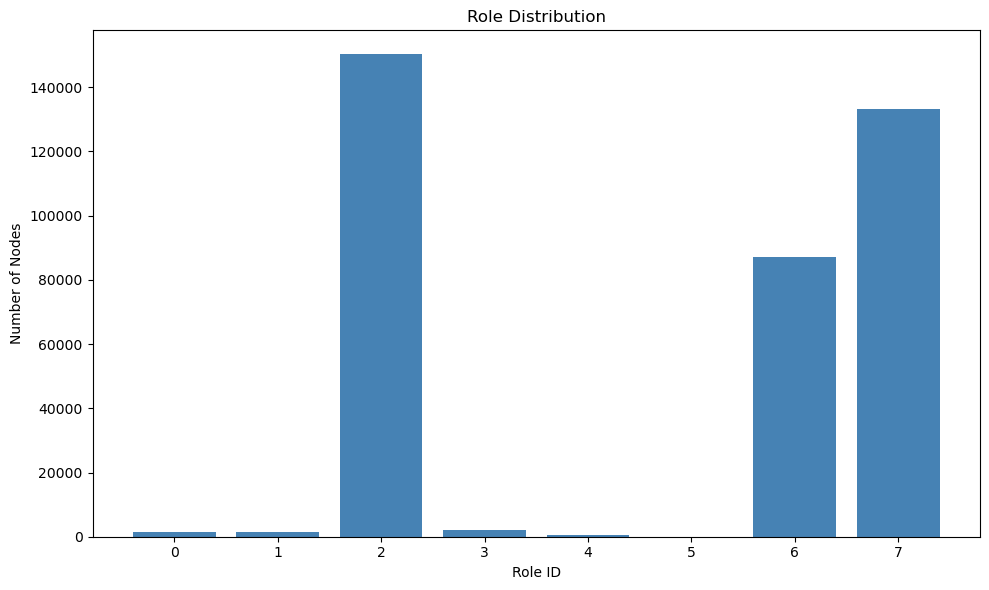

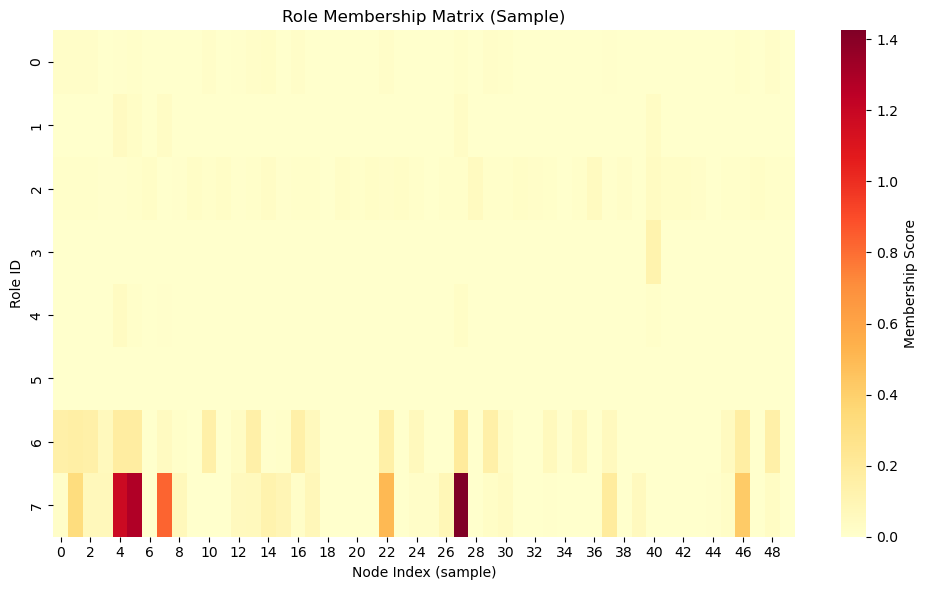

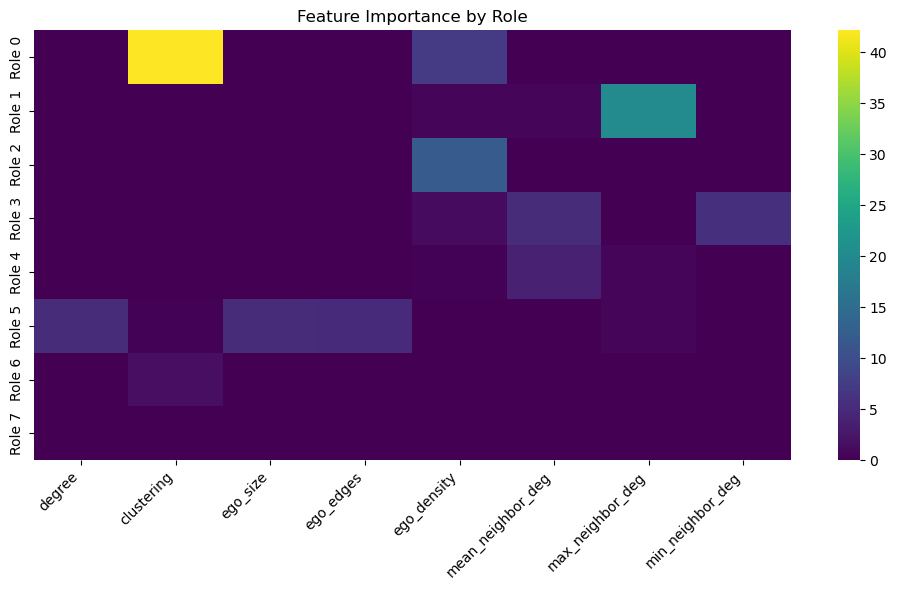

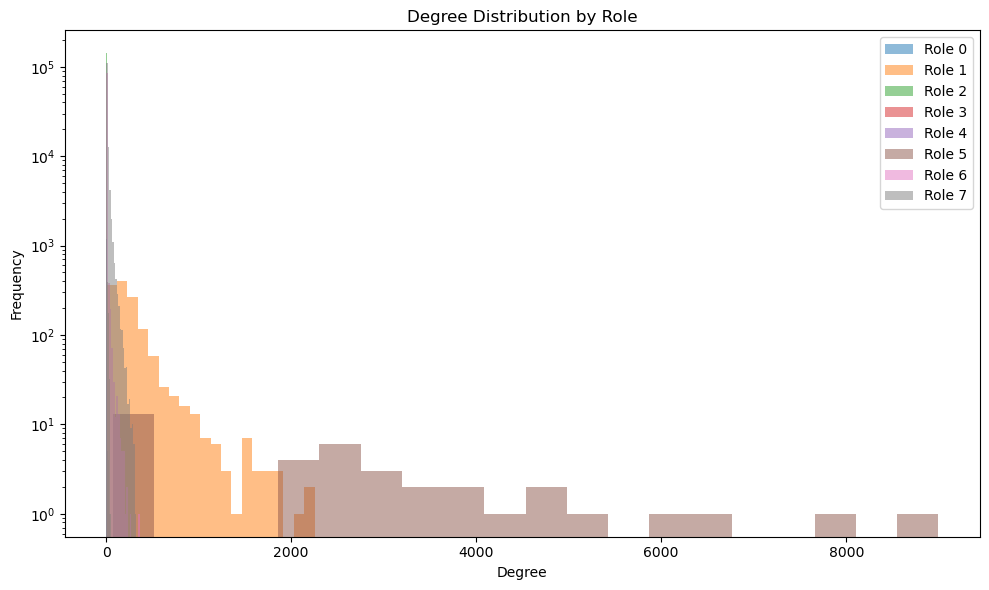

In [ ]:
# plot 1: role distribution
plt.figure(figsize=(10, 6))
role_counts = pd.Series(primary_roles).value_counts().sort_index()
plt.bar(role_counts.index, role_counts.values, color='steelblue')
plt.xlabel('Role ID')
plt.ylabel('Number of Nodes')
plt.title('Role Distribution')
plt.xticks(range(n_roles))
plt.tight_layout()
plt.show()

# plot 2: role membership heatmap (sample of nodes)
plt.figure(figsize=(10, 6))
sample_indices = np.random.choice(len(role_membership), min(50, len(role_membership)), replace=False)
sample_membership = role_membership[sample_indices]
sns.heatmap(sample_membership.T, cmap='YlOrRd', cbar_kws={'label': 'Membership Score'})
plt.xlabel('Node Index (sample)')
plt.ylabel('Role ID')
plt.title('Role Membership Matrix (Sample)')
plt.tight_layout()
plt.show()

# plot 3: feature importance per role
plt.figure(figsize=(10, 6))
feature_importance = nmf.components_
sns.heatmap(feature_importance, cmap='viridis', 
            xticklabels=feature_names, yticklabels=[f'Role {i}' for i in range(n_roles)])
plt.title('Feature Importance by Role')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# plot 4: degree distribution by role
plt.figure(figsize=(10, 6))
for role_id in range(n_roles):
    role_mask = primary_roles == role_id
    role_degrees = feature_matrix[role_mask, 0]  # degree is out first feature
    plt.hist(role_degrees, alpha=0.5, label=f'Role {role_id}', bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution by Role')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()